# LSTM Multivariate forecasting with multiple lags

In [1]:
from utilities.std_imports import *
from utilities.tf_imports import *

import sklearn.preprocessing as skp
import sklearn.metrics as skm
import time_series.LSTM.LSTM_ts_utilities as tsu

### Load data

In [2]:
ds = pd.read_csv(csv_path + 'pollution.csv', header=0, index_col=0)
values = ds.values
ds.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


### Encoding

In [3]:
print(values[:,4])
encoder = skp.LabelEncoder()

values[:,4] = encoder.fit_transform(values[:,4])
values = values.astype('float32')
print(values[:,4])

scaler = skp.MinMaxScaler(feature_range=(0, 1))
values_sc = scaler.fit_transform(values)
print(values_sc[:,4])

['SE' 'SE' 'SE' ... 'NW' 'NW' 'NW']
[2. 2. 2. ... 1. 1. 1.]
[0.6666667  0.6666667  0.6666667  ... 0.33333334 0.33333334 0.33333334]


### Specify lags

In [8]:
n_lags = 3
n_features = 8
values_sc = pd.DataFrame(values_sc)

values_sup = tsu.build_ds_uni(ds=values_sc, mw=n_lags, fh=1)
values_sup.dropna(inplace=True)
values_sup.shape

(43797, 32)

### Prepare data

In [9]:
values = values_sup.values
n_train_hours = 365 * 24
ds_train = values[:n_train_hours, :]
ds_test = values[n_train_hours:, :]

# split into input and outputs
n_obs = n_lags * n_features
X_train, y_train = ds_train[:, :n_obs], ds_train[:, -n_features]
X_test, y_test = ds_test[:, :n_obs], ds_test[:, -n_features]
print(X_train.shape, len(X_train), y_train.shape)

# reshape to [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], n_lags, n_features))
X_test = X_test.reshape((X_test.shape[0], n_lags, n_features))
X_train.shape, y_train.shape, X_test.shape, y_test.shape

(8760, 24) 8760 (8760,)


((8760, 3, 8), (8760,), (35037, 3, 8), (35037,))

### Build model

Epoch 1/50
122/122 - 3s - loss: 0.0517 - val_loss: 0.0684
Epoch 2/50
122/122 - 1s - loss: 0.0265 - val_loss: 0.0437
Epoch 3/50
122/122 - 1s - loss: 0.0219 - val_loss: 0.0297
Epoch 4/50
122/122 - 1s - loss: 0.0213 - val_loss: 0.0251
Epoch 5/50
122/122 - 1s - loss: 0.0209 - val_loss: 0.0238
Epoch 6/50
122/122 - 1s - loss: 0.0206 - val_loss: 0.0214
Epoch 7/50
122/122 - 1s - loss: 0.0197 - val_loss: 0.0192
Epoch 8/50
122/122 - 1s - loss: 0.0192 - val_loss: 0.0184
Epoch 9/50
122/122 - 1s - loss: 0.0190 - val_loss: 0.0179
Epoch 10/50
122/122 - 1s - loss: 0.0183 - val_loss: 0.0173
Epoch 11/50
122/122 - 1s - loss: 0.0179 - val_loss: 0.0170
Epoch 12/50
122/122 - 1s - loss: 0.0176 - val_loss: 0.0168
Epoch 13/50
122/122 - 1s - loss: 0.0173 - val_loss: 0.0170
Epoch 14/50
122/122 - 1s - loss: 0.0169 - val_loss: 0.0167
Epoch 15/50
122/122 - 1s - loss: 0.0164 - val_loss: 0.0159
Epoch 16/50
122/122 - 1s - loss: 0.0162 - val_loss: 0.0156
Epoch 17/50
122/122 - 1s - loss: 0.0160 - val_loss: 0.0158
Epoch 

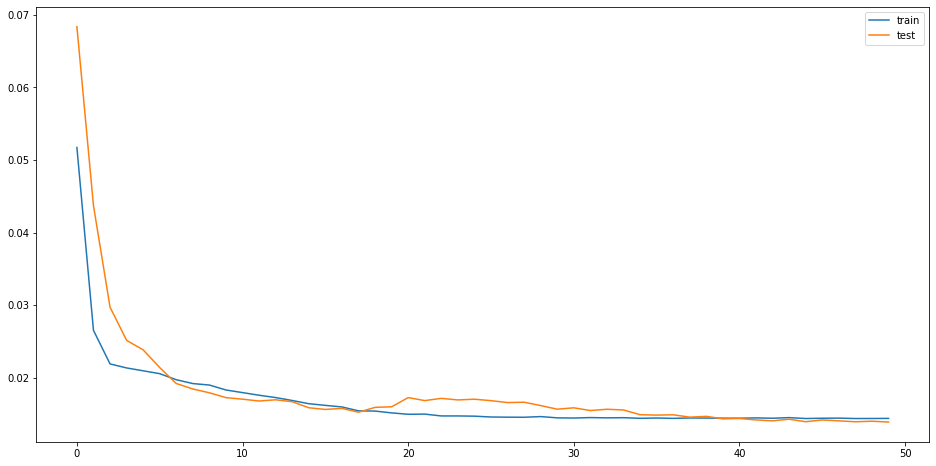

In [10]:
model = tkm.Sequential()
model.add(tkl.LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(tkl.Dense(1))
model.compile(loss='mae', optimizer='adam')

history = model.fit(X_train, y_train, epochs=50, batch_size=72, validation_data=(X_test, y_test), verbose=2, shuffle=False)

plt.figure(figsize=[16,8])
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

### Predict

In [11]:
pred = model.predict(X_test)
X_test_rs = X_test.reshape((X_test.shape[0], n_lags * n_features))
y_test_rs = y_test.reshape((len(y_test), 1))

# invert scaling 
pred_unsc = np.concatenate((pred, X_test_rs[:, -7:]), axis=1)
pred_unsc = scaler.inverse_transform(pred_unsc)
pred_unsc = pred_unsc[:,0]

label_unsc = np.concatenate((y_test_rs, X_test_rs[:, -7:]), axis=1)
label_unsc = scaler.inverse_transform(label_unsc)
label_unsc = label_unsc[:,0]

# calculate RMSE
rmse = np.sqrt(skm.mean_squared_error(label_unsc, pred_unsc))
round(rmse,2)

26.5

### Credits & Links

https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/